In [1]:
import numpy as np
import matplotlib.pyplot as plt
import caffe
import pandas as pd

%matplotlib inline

In [2]:
caffe.set_mode_gpu()

model_def = '/home/navarro/repos/caffe-moon/deploy.prototxt'
model_weights = '/home/navarro/repos/caffe-moon/models/moon_tiny_iter_1000000.caffemodel'

net = caffe.Net(model_def, model_weights,caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [3]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [4]:
test_file = '/mnt/6C126E47126E167C/data/facedataset_local/celebA-img-align/list_attr_celeba_test.txt'
lines = []

net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          218, 178)  # image size is 227x227
with open(test_file, 'r') as fin:
    lines = fin.readlines()
    
total_error = np.zeros(40)
count = len(lines)

attrib_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
                'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
                'Black_Hair', 'Blond_Hair', 'Blurry',
                'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
                'Double_Chin', 'Eyeglasses', 'Goatee',
                'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
                'Male', 'Mouth_Slightly_Open', 'Mustache',
                'Narrow_Eyes', 'No_Beard', 'Oval_Face',
                'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                'Rosy_Cheeks', 'Sideburns', 'Smiling',
                'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
                'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
                'Wearing_Necktie', 'Young']

for line in lines:
    name_attr = line.strip().replace('  ', ' ').split(' ')
    path = '/mnt/6C126E47126E167C/data/facedataset_local/celebA-img-align/images/' + name_attr[0]
    attr = [int(a) for a in name_attr[1:]]
    
    # load image and prepare as a single input batch for Caffe
    im = np.array(caffe.io.load_image(path, color=True)).squeeze()
    transformed_image = transformer.preprocess('data', im)
    net.blobs['data'].data[...] = transformed_image*0.003922
    output = net.forward()
    out = np.sign(output['moon-fc'][0])
    res = attr - out
    total_error += 0.5*np.abs(res)

#     plt.title("original image")
#     plt.imshow(im)
#     plt.axis('on')


avg_error = total_error/count


,avg error
Bald,0.021190
Eyeglasses,0.021240
Gray_Hair,0.030508
Sideburns,0.035668
Pale_Skin,0.038724
Mustache,0.039425
Goatee,0.039776
Double_Chin,0.043633
Wearing_Hat,0.044785
Blurry,0.047590


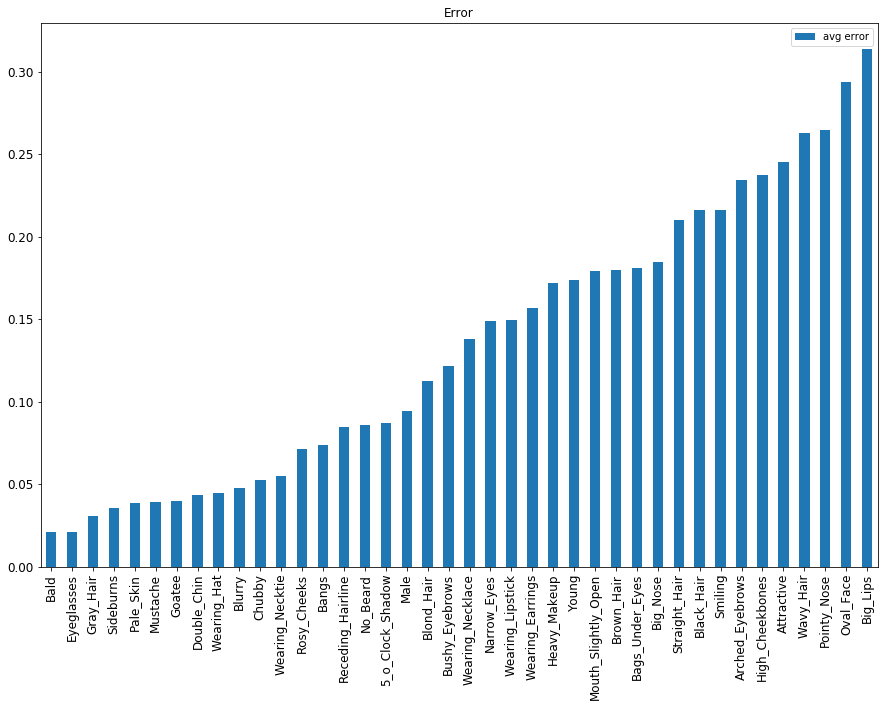

In [5]:
df = pd.DataFrame(avg_error, attrib_names)
df.columns = ['avg error']
df = df.sort_values(by=['avg error'])
df.plot(kind='bar', title ="Error", figsize=(15, 10), legend=True, fontsize=12)
display(df)